# CS 429: Information Retrieval

<br>
## Lecture 3: Indexing II

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


---
<br><br><br>

# Recall Inverted Index

![diagrams-0](files/diagrams-0.png)



## To merge two postings lists

![merge](files/merge.png)

Runtime: $O(x + y)$, for postings lists of size $x$ and $y$

<br><br><br><br><br><br><br><br>

# Skip Lists

![diagrams-1](files/diagrams-1.png)

Worst-case runtime? 

$O(x + y)$

Best-case runtime?

$O(k)$, for $k$ matching documents

# Merging Skip Lists

In [22]:
# tuple (x,y,z): x=doc_id, y=skip index, z=skip value
index = {'cat': [(2, 3, 16), 4, 8, (16, 6, 28), 19, 23, 28, 43],
         'dog': [(1, 3, 5), 2, 3, (5, 6, 51), 8, 41, 51, 60, 71]}






In [23]:
# Print postings list containing skip pointers.
def print_skip_list(docs):
    idx = 0
    while idx < len(docs):
        print(docs[idx])
        if type(docs[idx]) is tuple: # skip
            idx = docs[idx][1]
        else:
            idx += 1
            
            
            
            
            

In [24]:
print_skip_list(index['cat'])

(2, 3, 16)
(16, 6, 28)
28
43


In [25]:
print_skip_list(index['dog'])

(1, 3, 5)
(5, 6, 51)
51
60
71


![skip_merge](files/skip_merge.png)

# Where to insert skip pointers?

Tradeoff:

- More pointers mean more opportunities to skip 
- Fewer pointers means less time wasted comparing to skip values.
- Heuristic: $\sqrt{n}$ evenly-spaced pointers, for list of size $n$.

![diagrams-2](files/diagrams-2.png)

# Adding to an index with skip pointers

What happens when we have to add a document to a postings list?



If postings list is a ...

- linked list
- dynamic array (e.g., ArrayList)

# Phrase queries

"cat dog" **vs** cat AND dog



![catdog](files/CatDog.jpeg) <img src="files/cat_and_dog.jpg" width=40%/>

# Phrase Indexing

Two approaches

1. **Biword Index**
2. **Positional Index**

# Biword index

"The cat dog jumped."

![diagrams-3](files/diagrams-3.png)

# Finding phrases

In [26]:
docs = [l.strip() for l in open("documents.txt", 'rt').readlines()]
print('read', len(docs), 'docs')

read 62 docs


In [28]:
def ngrams(n, docs):
    terms = set()
    for d in docs:
        toks = d.split()
        for i in range(len(toks) - n + 1):
            terms.add('_'.join(toks[i:i+n]))
    return terms

In [29]:
print(ngrams(1, ['a b c']))
print(ngrams(2, ['a b c']))
print(ngrams(3, ['a b c']))
print(ngrams(4, ['a b c']))

{'b', 'a', 'c'}
{'b_c', 'a_b'}
{'a_b_c'}
set()


In [30]:
max_n = 20
sizes = [len(ngrams(i, docs)) for i in range(1, max_n)]
print('number of terms=')
list(zip(range(1, max_n), sizes))

number of terms=


[(1, 380),
 (2, 585),
 (3, 599),
 (4, 567),
 (5, 511),
 (6, 452),
 (7, 391),
 (8, 330),
 (9, 272),
 (10, 221),
 (11, 172),
 (12, 129),
 (13, 90),
 (14, 61),
 (15, 40),
 (16, 28),
 (17, 22),
 (18, 17),
 (19, 14)]

Populating the interactive namespace from numpy and matplotlib
[380, 965, 1564, 2131, 2642, 3094, 3485, 3815, 4087, 4308, 4480, 4609, 4699, 4760, 4800, 4828, 4850, 4867, 4881]


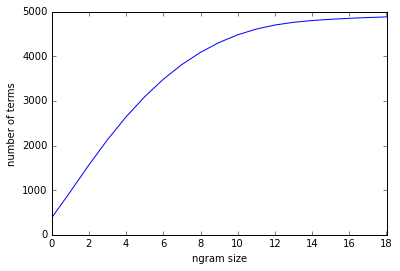

In [31]:
%pylab inline
# 1-grams, 1-grams + 2-grams, ...
x = [sum(sizes[:i]) for i in range(1,max_n)]
print(x)
plot(x)
xlabel('ngram size')
ylabel('number of terms')

# Limits of phrase indices

If we index 5-grams, how can we search for the phrase "to be or not to be"?

- AND of 5-grams "to be or not to" AND "be or not to be"
- Very small possibility of a false match

What if we index 2-grams and we search for the phrase "new york university"

- "new york" AND "york university"
- greater possibility of false match

# Positional Index

- Store position of term in original document.
- *term*: [(doc_id1, [pos1, pos2, ...]), (doc_id2, [pos1, pos2, ...]), ...]

In [33]:
doc0 = "The cat dog jumped over the dog."
doc1 = "The dog jumped."
index = {
         'the': [(0, [0, 5]), (1, [0])],
         'cat': [(0, [1])],
         'dog': [(0, [2, 6]), (1, 1)],
         'jumped': [(0, [3]), (1, [2])]
         }

# Positional Index

- Additional space needed?

- One `int` for each time a term occurs in a document.
- Biggest impact on long documents.
- E.g., consider a term that occurs once every thousand words:

|document length | # postings | # positional postings|
|----------------|------------|----------------------|
|1000            |  1         | 1                    |
|100,000         |  1         | 100                  |


# Merging positional postings lists

How can we efficiently merge positional postings lists to find phrases?

In [34]:
index = {'cat': [(0, [1])],
         'dog': [(0, [2, 6]),
                 (1, [1])]}
# [ (doc_id1, [pos1, pos2, ...]),
#   (doc_id2, [pos1, pos2, ...]), ...
# ]

# Search for "cat dog"
# This is inefficient! See Figure 2.12 (from book) and next assignment for more.
for cat_doc in index['cat']:
    for dog_doc in index['dog']:
        if cat_doc[0] == dog_doc[0]:  # In same document
            print('both appear in ', cat_doc[0])
            for cat_pos in cat_doc[1]:
                for dog_pos in dog_doc[1]:
                    if cat_pos == dog_pos - 1: # dog comes right after cat.
                        print('found "cat dog" at positions', cat_pos, dog_pos)

both appear in  0
found "cat dog" at positions 1 2


# Combining Biword Index and Positional Index

- Only store phrases that
  - Are commonly queried
  - Have common individual words
- *Britney Spears* vs. *The Who*

![diagrams-4](files/diagrams-4.png)

1. How often is a skip pointer followed (i.e., p1 is advanced to skip(p1))?
2. How many postings comparisons will be made by this algorithm while intersecting the two lists?
3. How many postings comparisons would be made if the postings lists are intersected without the use of skip pointers?
4. Repeat number 2 considering also the overhead costs (e.g., checking if an element has a skip and comparing the value of the target of the skip).